In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.nn import Linear, Dropout, LayerNorm, BatchNorm1d
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch_geometric as T
from torch_geometric.nn import GCNConv, SAGEConv, GraphConv, GATConv, global_mean_pool, global_add_pool, global_max_pool
from torch.nn.utils import clip_grad_norm_
from torch.optim.lr_scheduler import ReduceLROnPlateau

import networkx as nx

from sklearn.metrics import roc_curve, roc_auc_score
from statistics import mean
import random
from sklearn.preprocessing import StandardScaler

In [2]:
# Read from csv
sig_df = pd.read_csv('Dijet_bb_pt20_50_dw.csv')
bkg_df = pd.read_csv('Dijet_qq_pt20_50_dw.csv')

In [26]:
# Distinguish signal and background
sig_df['IsB'] = 1
bkg_df['IsB'] = 0

# Separate Jet 0 and Jet 1 data
sig_isb_df = sig_df[sig_df.columns[sig_df.columns.str.contains("Jet0|IsB")]]
bkg_isb_df = bkg_df[bkg_df.columns[bkg_df.columns.str.contains("Jet0|IsB")]]

# Combine signal and background and shuffle
df = pd.concat([sig_isb_df, bkg_isb_df])

In [27]:
df

,Jet0_ENDVERTEX_X,Jet0_ENDVERTEX_Y,Jet0_ENDVERTEX_Z,Jet0_ENDVERTEX_XERR,Jet0_ENDVERTEX_YERR,Jet0_ENDVERTEX_ZERR,Jet0_ENDVERTEX_CHI2,Jet0_ENDVERTEX_NDOF,Jet0_OWNPV_X,Jet0_OWNPV_Y,...,Jet0_Hlt1Phys_Dec,Jet0_Hlt1Phys_TIS,Jet0_Hlt1Phys_TOS,Jet0_Hlt2Global_Dec,Jet0_Hlt2Global_TIS,Jet0_Hlt2Global_TOS,Jet0_Hlt2Phys_Dec,Jet0_Hlt2Phys_TIS,Jet0_Hlt2Phys_TOS,IsB
0,0.8738,-0.1754,14.7203,0.0093,0.0093,0.0573,49.857929,107,0.766100,-0.200700,...,True,True,True,True,True,True,True,True,True,1
1,0.7844,-0.1852,-61.7426,0.0074,0.0073,0.0379,68.600578,167,0.783929,-0.185155,...,True,True,True,True,True,True,True,True,True,1
2,0.8658,-0.1414,-9.7498,0.0101,0.0101,0.0570,21.601925,57,0.862175,-0.136493,...,True,True,True,True,True,True,True,True,False,1
3,0.8803,-0.1820,28.3628,0.0094,0.0093,0.0503,40.823803,91,0.881767,-0.183634,...,True,True,True,True,True,True,True,True,True,1
4,0.8163,-0.0868,8.4282,0.0286,0.0275,0.3193,7.705523,13,0.799059,-0.161079,...,False,False,False,True,False,False,True,False,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,0.9319,-0.1551,-26.4473,0.0114,0.0115,0.0678,23.666225,51,0.931997,-0.157303,...,False,False,False,True,False,False,True,False,False,0
199996,0.9319,-0.1551,-26.4473,0.0114,0.0115,0.0678,23.666225,51,0.931997,-0.157303,...,False,False,False,True,False,False,True,False,False,0
199997,0.9319,-0.1551,-26.4473,0.0114,0.0115,0.0678,23.666225,51,0.931997,-0.157303,...,False,False,False,True,False,False,True,False,False,0
199998,0.9319,-0.1551,-26.4473,0.0114,0.0115,0.0678,23.666225,51,0.931287,-0.153498,...,False,False,False,True,False,False,True,False,False,0


In [28]:
# Create Gauss values for each daughter based on IsB column
def gaussian(mean, std_dev):
    return random.gauss(mean, std_dev)

def gaussian_list(row, mean1, mean2, std_dev):
    num_daughters = int(row['Jet0_nDaughters'])
    mean = mean1 if row['IsB'] == 1 else mean2
    return [gaussian(mean, std_dev) for _ in range(num_daughters)]

In [29]:
# Calculate eta phi, and r for muons (do before duplication)
def deltar():
    delta_r_values = []

    if df['Jet0_nmuons'].any() > 0:
        for i, row in df.iterrows():
            px = row['Jet0_muon_PE']
            py = row['Jet0_muon_PY']
            pz = row['Jet0_muon_PZ']
            p_mag = np.sqrt(px**2 + py**2 + pz**2)

            eta1 = 0.5 * np.log((p_mag + pz) / (p_mag - pz))
            phi1 = np.arctan2(py, px)

            eta2 = df.Jet0_Eta[i]
            phi2 = df.Jet0_Phi[i]
            delta_r = np.sqrt((eta2 - eta1)**2 + (phi2 - phi1)**2)
            delta_r_values.append(delta_r)
    else:
        delta_r_values.append(None)
    df['DeltaR'] = df.apply(lambda i: delta_r_values[i], axis=1)
    

# Truth matching & cuts
def truth_matching(df):
    tm_sig_df = df[(df['IsB'] == 1) &
                            (df['Jet0_MC_Match'] == 1) &
                            (df['Jet0_MC_Jet_EfB'] > 0.6) &
                            (df['Jet0_PT'] > 20000) &
                            (df['Jet0_Eta'] > 2.2) &
                            (df['Jet0_Eta'] < 4.4)]
    tm_bkg_df = df[(df['IsB'] == 0) &
                            (df['Jet0_MC_Match'] == 1) &
                            (df['Jet0_MC_Jet_EfB'] < 0.6) &
                            (df['Jet0_MC_Jet_EfD'] < 0.6) &
                            (df['Jet0_PT'] > 20000) &
                            (df['Jet0_Eta'] > 2.2) &
                            (df['Jet0_Eta'] < 4.4)]
    
    df = pd.concat([tm_sig_df, tm_bkg_df], ignore_index=True)
    return df

# Duplicate data to lists matching the number of daughters/ nodes per jet/ row
def duplicate(jet_cols, n_col):
    for col in jet_cols:
        df[col] = df.apply(lambda row: [row[col]] * row[n_col] if isinstance(row[col], (float, int)) else row[col], axis=1)
    return df

# Convert string values into list of floats
def convert_to_lists(daughter_cols):
    for col in daughter_cols:
        df[col] = df[col].apply(lambda x: [float(num) for num in x.strip('[]').split(',')] if isinstance(x, str) else x)
    return df

Data preprocessing

In [30]:
# Daughter features
daughter_cols = [col for col in df.columns if "_Daughters" in col]

# Jet features
jet_cols = ['Jet0_Eta', 'Jet0_PT']

# All features columns
feature_cols = daughter_cols + jet_cols

# Truth matching & cuts
df = truth_matching(df)

# Calculate Delta R

# Apply the function to create the new 'Gauss' column
df['Gauss'] = df.apply(lambda row: gaussian_list(row, 10, 25, 5), axis=1)

# Duplicate single features for each node
df = duplicate(jet_cols, 'Jet0_nDaughters')

# Convert strings into float lists
df = convert_to_lists(daughter_cols)

In [31]:
df

,Jet0_ENDVERTEX_X,Jet0_ENDVERTEX_Y,Jet0_ENDVERTEX_Z,Jet0_ENDVERTEX_XERR,Jet0_ENDVERTEX_YERR,Jet0_ENDVERTEX_ZERR,Jet0_ENDVERTEX_CHI2,Jet0_ENDVERTEX_NDOF,Jet0_OWNPV_X,Jet0_OWNPV_Y,...,Jet0_Hlt1Phys_TIS,Jet0_Hlt1Phys_TOS,Jet0_Hlt2Global_Dec,Jet0_Hlt2Global_TIS,Jet0_Hlt2Global_TOS,Jet0_Hlt2Phys_Dec,Jet0_Hlt2Phys_TIS,Jet0_Hlt2Phys_TOS,IsB,Gauss
0,0.8738,-0.1754,14.7203,0.0093,0.0093,0.0573,49.857929,107,0.766100,-0.200700,...,True,True,True,True,True,True,True,True,1,"[1.2579500952663576, 8.467440963165977, 5.2416..."
1,0.8658,-0.1414,-9.7498,0.0101,0.0101,0.0570,21.601925,57,0.862175,-0.136493,...,True,True,True,True,True,True,True,False,1,"[8.120767316313088, 10.325809066228786, 8.8841..."
2,0.8803,-0.1820,28.3628,0.0094,0.0093,0.0503,40.823803,91,0.881767,-0.183634,...,True,True,True,True,True,True,True,True,1,"[4.735785220883089, 12.111461170405127, 12.906..."
3,0.8163,-0.0868,8.4282,0.0286,0.0275,0.3193,7.705523,13,0.811200,-0.098801,...,False,False,True,False,False,True,False,False,1,"[13.169432193949667, 2.541633934101762, 5.3690..."
4,0.8163,-0.0868,8.4282,0.0286,0.0275,0.3193,7.705523,13,0.811200,-0.098801,...,False,False,True,False,False,True,False,False,1,"[20.972435225534035, 8.707028761672504, 18.182..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137087,0.8769,-0.2248,42.3909,0.0252,0.0213,0.2080,10.417310,25,0.880671,-0.233220,...,True,True,True,True,True,True,True,True,0,"[24.696768657136346, 22.678997771460473, 20.92..."
137088,0.9319,-0.1551,-26.4473,0.0114,0.0115,0.0678,23.666225,51,0.931997,-0.157303,...,False,False,True,False,False,True,False,False,0,"[37.71771512287306, 20.705026263519187, 23.057..."
137089,0.9319,-0.1551,-26.4473,0.0114,0.0115,0.0678,23.666225,51,0.931997,-0.157303,...,False,False,True,False,False,True,False,False,0,"[19.90805416551022, 22.87447001150673, 29.4482..."
137090,0.9319,-0.1551,-26.4473,0.0114,0.0115,0.0678,23.666225,51,0.931997,-0.157303,...,False,False,True,False,False,True,False,False,0,"[33.22808970860617, 31.88669829074415, 23.2719..."


In [32]:
# Split data 80:20 w equal parts sig/bkg
df_isb_1 = df[df['IsB'] == 1]
df_isb_0 = df[df['IsB'] == 0]

train_df = pd.concat([df_isb_1.head(12000), df_isb_0.head(12000)]).sample(frac=1, random_state=42).reset_index(drop=True)
test_df = pd.concat([df_isb_1.tail(3000), df_isb_0.tail(3000)]).sample(frac=1, random_state=42).reset_index(drop=True)

In [33]:
sum(train_df.IsB)

12000

In [34]:
sum(test_df.IsB)

3000

In [35]:
training_data = train_df[feature_cols]
testing_data = test_df[feature_cols]

In [36]:
training_data

,Jet0_Daughters_E,Jet0_Daughters_pT,Jet0_Daughters_ID,Jet0_Daughters_pX,Jet0_Daughters_pY,Jet0_Daughters_pZ,Jet0_Daughters_Eta,Jet0_Daughters_Phi,Jet0_Daughters_Q,Jet0_Daughters_IP,...,Jet0_Daughters_trackZ,Jet0_Daughters_trackVX,Jet0_Daughters_trackVY,Jet0_Daughters_trackVZ,Jet0_Daughters_CaloNeutralEcal,Jet0_Daughters_CaloNeutralHcal2Ecal,Jet0_Daughters_CaloNeutralE49,Jet0_Daughters_CaloNeutralPrs,Jet0_Eta,Jet0_PT
0,"[13194.3984375, 5563.22021484375, 5035.3046875...","[343.78204345703125, 166.88829040527344, 220.3...","[211.0, 22.0, 211.0, 321.0, -211.0, -211.0, -2...","[-259.6786193847656, -116.18250274658203, -125...","[-225.28451538085938, -119.80538177490234, -18...","[13189.1806640625, 5560.71630859375, 5028.5434...","[4.340461254119873, 4.199529647827148, 3.82117...","[-2.426996946334839, -2.340843677520752, -2.17...","[1.0, 0.0, 1.0, 1.0, -1.0, -1.0, -1.0, 1.0, 0....","[-0.0035699785221368074, -100.0, -0.1688256263...",...,"[-95.42870330810547, -1000.0, -48.695301055908...","[-259.6786193847656, -1000.0, -125.53617858886...","[-225.28451538085938, -1000.0, -181.1249694824...","[13189.1806640625, -1000.0, 5028.54345703125, ...","[-1000.0, 5563.22021484375, -1000.0, -1000.0, ...","[-1000.0, 0.7478656768798828, -1000.0, -1000.0...","[-1000.0, 0.8745050430297852, -1000.0, -1000.0...","[-1000.0, 2.19417405128479, -1000.0, -1000.0, ...","[3.886552746484725, 3.886552746484725, 3.88655...","[27315.759800558204, 27315.759800558204, 27315..."
1,"[13017.5146484375, 4414.18994140625, 5769.8090...","[699.377197265625, 257.1174621582031, 399.1422...","[321.0, 22.0, 22.0, 22.0, -211.0, 22.0, -22.0,...","[571.3621826171875, 244.7260284423828, 397.586...","[403.3283386230469, 78.85781860351562, -35.205...","[12989.3359375, 4406.6953125, 5755.98681640625...","[3.6155648231506348, 3.5353446006774902, 3.363...","[0.6146791577339172, 0.3117235600948334, -0.08...","[1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 1.0,...","[-0.05803072825074196, -100.0, -100.0, -100.0,...",...,"[-25.029300689697266, -1000.0, -1000.0, -1000....","[571.3621826171875, -1000.0, -1000.0, -1000.0,...","[403.3283386230469, -1000.0, -1000.0, -1000.0,...","[12989.3359375, -1000.0, -1000.0, -1000.0, 453...","[-1000.0, 4663.58984375, -1000.0, 6158.0161132...","[-1000.0, 0.40570762753486633, -1000.0, 1.7905...","[-1000.0, 0.7293347716331482, -1000.0, 0.80865...","[-1000.0, 29.347076416015625, -1000.0, 61.1626...","[3.1544650018810767, 3.1544650018810767, 3.154...","[26036.782428539587, 26036.782428539587, 26036..."
2,"[3446.7060546875, 22096.01953125, 5585.25, 410...","[162.46437072753906, 1647.8843994140625, 628.9...","[22.0, -2212.0, 22.0, 22.0, 22.0, 22.0, 211.0,...","[50.24778747558594, 780.0322875976562, 46.4706...","[154.49864196777344, 1451.5758056640625, 627.1...","[3442.875, 22014.5, 5549.72802734375, 4092.927...","[3.7473068237304688, 3.2867541313171387, 2.873...","[1.2563552856445312, 1.0777020454406738, 1.496...","[0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0,...","[-100.0, -0.07602924853563309, -100.0, -100.0,...",...,"[-1000.0, 2334.25, -1000.0, -1000.0, -1000.0, ...","[-1000.0, 780.0322875976562, -1000.0, -1000.0,...","[-1000.0, 1451.5758056640625, -1000.0, -1000.0...","[-1000.0, 22014.5, -1000.0, -1000.0, -1000.0, ...","[3446.7060546875, -1000.0, 4973.052734375, -10...","[1.049729824066162, -1000.0, 0.0, -1000.0, 0.0...","[0.8619195818901062, -1000.0, 0.86763828992843...","[67.4708480834961, -1000.0, 91.05821990966797,...","[3.370216483507379, 3.370216483507379, 3.37021...","[33854.854907421264, 33854.854907421264, 33854..."
3,"[38320.78125, 4578.4677734375, 11788.580078125...","[3829.4521484375, 403.346435546875, 1281.64343...","[22.0, -211.0, 22.0, 22.0, -211.0, 22.0, 22.0,...","[-3535.61669921875, -376.6382751464844, -424.8...","[-1471.0943603515625, -144.33277893066406, -12...","[38128.95703125, 4558.5302734375, 11718.703125...","[2.9939117431640625, 3.120058536529541, 2.9091...","[-2.747302770614624, -2.7756407260894775, -1.9...","[0.0, -1.0, 0.0, 0.0, -

In [37]:
testing_data

,Jet0_Daughters_E,Jet0_Daughters_pT,Jet0_Daughters_ID,Jet0_Daughters_pX,Jet0_Daughters_pY,Jet0_Daughters_pZ,Jet0_Daughters_Eta,Jet0_Daughters_Phi,Jet0_Daughters_Q,Jet0_Daughters_IP,...,Jet0_Daughters_trackZ,Jet0_Daughters_trackVX,Jet0_Daughters_trackVY,Jet0_Daughters_trackVZ,Jet0_Daughters_CaloNeutralEcal,Jet0_Daughters_CaloNeutralHcal2Ecal,Jet0_Daughters_CaloNeutralE49,Jet0_Daughters_CaloNeutralPrs,Jet0_Eta,Jet0_PT
0,"[6920.02978515625, 1051.6800537109375, 8139.60...","[547.5479125976562, 203.30328369140625, 1089.0...","[22.0, 22.0, 310.0, 22.0, -13.0, 211.0, 22.0, ...","[508.78350830078125, 178.151123046875, 789.351...","[202.35629272460938, 97.95101928710938, 750.23...","[6898.33349609375, 1031.84228515625, 8052.3144...","[3.2283036708831787, 2.3271162509918213, 2.698...","[0.37854427099227905, 0.5027048587799072, 0.75...","[0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, -1.0,...","[-100.0, -100.0, 0.0038935430347919464, -100.0...",...,"[-1000.0, -1000.0, -1000.0, -1000.0, 9.8851003...","[-1000.0, -1000.0, -1000.0, -1000.0, 1643.9986...","[-1000.0, -1000.0, -1000.0, -1000.0, 197.40724...","[-1000.0, -1000.0, -1000.0, -1000.0, 9464.6318...","[6636.7421875, 959.0387573242188, -1000.0, 369...","[0.0, 0.0, -1000.0, 0.3140113055706024, -1000....","[0.9347283840179443, 0.938793420791626, -1000....","[31.54125213623047, 5.4854350090026855, -1000....","[2.8021722371636835, 2.8021722371636835, 2.802...","[26751.333024081192, 26751.333024081192, 26751..."
1,"[26261.1484375, 8779.4794921875, 29934.875, 28...","[225.43507385253906, 325.0428466796875, 1186.2...","[310.0, 211.0, 211.0, -22.0, -211.0, -2212.0, ...","[-92.347900390625, -210.78062438964844, -758.8...","[205.6522216796875, 247.4356231689453, 911.684...","[26255.36328125, 8772.3505859375, 29911.039062...","[5.450758934020996, 3.9888932704925537, 3.9210...","[1.9928590059280396, 2.276369571685791, 2.2649...","[0.0, 1.0, 1.0, 0.0, -1.0, -1.0, -1.0, -1.0, 1...","[-0.012132476083934307, -0.1780140995979309, -...",...,"[-1000.0, -16.953699111938477, -16.16869926452...","[-1000.0, -210.78062438964844, -758.8834228515...","[-1000.0, 247.4356231689453, 911.6842651367188...","[-1000.0, 8772.3505859375, 29911.0390625, -100...","[-1000.0, -1000.0, -1000.0, -1000.0, -1000.0, ...","[-1000.0, -1000.0, -1000.0, -1000.0, -1000.0, ...","[-1000.0, -1000.0, -1000.0, -1000.0, -1000.0, ...","[-1000.0, -1000.0, -1000.0, -1000.0, -1000.0, ...","[4.190061562239837, 4.190061562239837, 4.19006...","[24755.58379560453, 24755.58379560453, 24755.5..."
2,"[10509.46875, 12725.69921875, 35021.20703125, ...","[979.3221435546875, 902.8726196289062, 1977.67...","[22.0, 22.0, -22.0, 22.0, 22.0, 22.0, 22.0, 22...","[-972.384033203125, -873.8942260742188, -1919....","[116.36650085449219, -226.9093017578125, -476....","[10463.740234375, 12693.6298828125, 34965.3203...","[3.064140558242798, 3.33768367767334, 3.566381...","[3.0224876403808594, -2.887549638748169, -2.89...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0,...","[-100.0, -100.0, -100.0, -100.0, -100.0, -100....",...,"[-1000.0, -1000.0, -1000.0, -1000.0, -1000.0, ...","[-1000.0, -1000.0, -1000.0, -1000.0, -1000.0, ...","[-1000.0, -1000.0, -1000.0, -1000.0, -1000.0, ...","[-1000.0, -1000.0, -1000.0, -1000.0, -1000.0, ...","[-1000.0, -1000.0, -1000.0, 6696.9892578125, -...","[-1000.0, -1000.0, -1000.0, 3.195282459259033,...","[-1000.0, -1000.0, -1000.0, 0.7151361107826233...","[-1000.0, -1000.0, -1000.0, 86.12133026123047,...","[3.597353644840281, 3.597353644840281, 3.59735...","[30872.651455233987, 30872.651455233987, 30872..."
3,"[847.5651245117188, 19864.900390625, 2547.2963...","[112.17701721191406, 2071.61328125, 281.735961...","[22.0, 211.0, 211.0, 211.0, -321.0, -211.0, -3...","[-59.73692321777344, -276.191162109375, -111.9...","[-94.94831848144531, -2053.11962890625, -258.5...","[840.10888671875, 19756.09375, 2527.8181152343...","[2.7110283374786377, 2.951019048690796, 2.8903...","[-2.132375717163086, -1.7045162916183472, -1.9...","[0.0, 1.0, 1.0, 1.0, -1

In [62]:
# Create node feature array: [jet][daughter][feature]
def node_features(df):
    features_list = []
    
    for _, row in df.iterrows():

        max_nodes = max(len(row[col]) if isinstance(row[col], list) else 1 for col in feature_cols)
        jet_nodes = [[] for _ in range(max_nodes)]
        
        for column in feature_cols:
            cell_value = row[column]

            if isinstance(cell_value, list):
                for i in range(max_nodes):
                    jet_nodes[i].append(cell_value[i])
            else:
                for node_features in jet_nodes:
                    node_features.append(cell_value)
        
        features_list.append(jet_nodes)
    
    return np.array(features_list, dtype=object)

# Create graphs for each jet - orig
def create_data_objects(df, features_array):
    data_objects = []
    for idx, features in enumerate(features_array):

        x = torch.tensor(features, dtype=torch.float)

        num_nodes = x.size(0)
        num_classes = 2 # binary classification

        # Fully connected edges
        G = nx.complete_graph(num_nodes)
        edge_index = torch.tensor(list(G.edges)).t().contiguous()

        y = torch.tensor([df['IsB'].iloc[idx]], dtype=torch.float)
        
        data = Data(x=x, edge_index=edge_index, y=y, num_classes=num_classes, num_nodes=num_nodes)
        data_objects.append(data)

    return data_objects

# Extract node features
train_features = node_features(train_df)
test_features = node_features(test_df)

# Create graphs for each jet
train_data = create_data_objects(train_df, train_features)
test_data = create_data_objects(test_df, test_features)

# Load Data in batches
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [170]:
class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        hidden_channels = 128
        self.conv1 = GraphConv(len(feature_cols), hidden_channels)
        self.bn1 = LayerNorm(hidden_channels)
        self.conv2 = GraphConv(hidden_channels, hidden_channels)
        self.bn2 = LayerNorm(hidden_channels)
        self.conv3 = GraphConv(hidden_channels, hidden_channels)
        self.bn3 = LayerNorm(hidden_channels)
        self.lin = Linear(hidden_channels, 1)
        self.dropout = torch.nn.Dropout(0.3)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv3(x, edge_index)
        x = self.bn3(x)
        x = F.relu(x)

        x = global_add_pool(x, batch)  # [batch_size, hidden_channels]
        
        x = self.lin(x)
        return x.squeeze(1)

model = GNN()

In [171]:
# Define optimizer and criterion
optimizer = optim.AdamW(model.parameters(), lr=1e-2, weight_decay=1e-4)
criterion = nn.BCEWithLogitsLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)


# Training loop
def train(loader):
    model.train()
    total_loss = 0

    for data in loader:
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = criterion(out, data.y.float())
        clip_grad_norm_(model.parameters(), max_norm=0.5)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
        
    return total_loss / len(train_loader.dataset)

# Testing function
def test(loader):
    model.eval()
    total_correct = 0
    total_samples = 0
    
    with torch.no_grad():
        for data in loader:
            out = model(data.x, data.edge_index, data.batch)
            pred = (out > 0).float()
            correct = (pred.squeeze() == data.y.float()).sum().item()
            total_correct += correct
            total_samples += len(data.y)
    
    return total_correct / total_samples

# Check gradients
def check_gradients():
    model.train()
    data = next(iter(train_loader))
    optimizer.zero_grad()
    out = model(data.x, data.edge_index, data.batch)
    loss = criterion(out.squeeze(-1), data.y.float())
    loss.backward()

    print(' ')
    print('Grad norms:')
    for name, param in model.named_parameters():
        if param.requires_grad:
            if param.grad is not None:
                grad_norm = param.grad.norm().item()
                print(f"    {name}: {grad_norm:.6f}")

# Training parameters
num_epochs = 200

# Lists to store loss and accuracy values
train_loss_values = []
test_loss_values = []
train_acc_values = []
test_acc_values = []

# Training loop
for epoch in range(num_epochs):
    trainloss = train(train_loader)
    testloss = train(test_loader)
    train_loss_values.append(trainloss)
    test_loss_values.append(testloss)
    train_acc = test(train_loader)
    train_acc_values.append(train_acc)
    test_acc = test(test_loader)
    test_acc_values.append(test_acc)
    scheduler.step(test_acc)

    print(f'Epoch: {epoch+1:03d}, Train Loss: {trainloss:.4f}, Test Loss: {testloss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

# Check gradients after training
check_gradients()

Epoch: 001, Loss: 0.9354, Train Acc: 0.5468, Test Acc: 0.5553
Epoch: 002, Loss: 0.6928, Train Acc: 0.5505, Test Acc: 0.5515
Epoch: 003, Loss: 0.6880, Train Acc: 0.5475, Test Acc: 0.5442
Epoch: 004, Loss: 0.6879, Train Acc: 0.5526, Test Acc: 0.5430
Epoch: 005, Loss: 0.6873, Train Acc: 0.5459, Test Acc: 0.5387
Epoch: 006, Loss: 0.6871, Train Acc: 0.5576, Test Acc: 0.5525
Epoch: 007, Loss: 0.6867, Train Acc: 0.5635, Test Acc: 0.5470
Epoch: 008, Loss: 0.6853, Train Acc: 0.5505, Test Acc: 0.5403
Epoch: 009, Loss: 0.6847, Train Acc: 0.5684, Test Acc: 0.5548
Epoch: 010, Loss: 0.6826, Train Acc: 0.5617, Test Acc: 0.5423
Epoch: 011, Loss: 0.6809, Train Acc: 0.5730, Test Acc: 0.5592
Epoch: 012, Loss: 0.6770, Train Acc: 0.5885, Test Acc: 0.5768
Epoch: 013, Loss: 0.6753, Train Acc: 0.5907, Test Acc: 0.5780
Epoch: 014, Loss: 0.6724, Train Acc: 0.5949, Test Acc: 0.5787
Epoch: 015, Loss: 0.6717, Train Acc: 0.6042, Test Acc: 0.5818
Epoch: 016, Loss: 0.6675, Train Acc: 0.5990, Test Acc: 0.5912
Epoch: 0

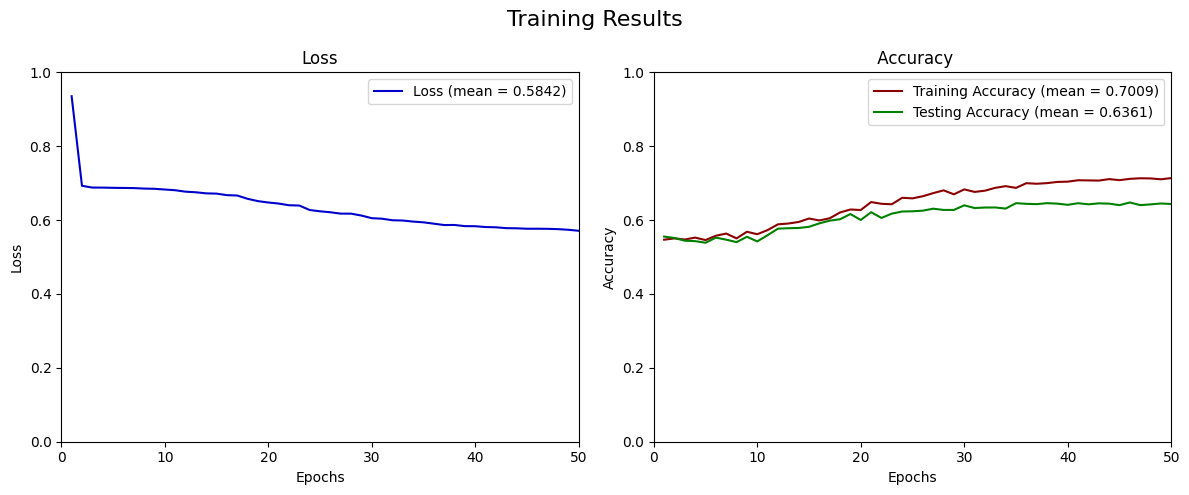

In [178]:
# Plot Loss and Accuracy
def plot_training_results(loss_values, train_acc_values, test_acc_values):
    epochs = range(1, len(loss_values) + 1)  # Create a list of epoch numbers
    mean_train_acc = mean(train_acc_values)
    mean_test_acc = mean(test_acc_values)
    mean_loss = mean(loss_values)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle('Training Results', fontsize=16)

    # Plot Loss
    ax1.plot(epochs, loss_values, color='mediumblue', label=(f"Loss (mean = {mean_loss:.4f})"))
    ax1.set_ylim(0, 1)
    ax1.set_xlim(0, 50)
    ax1.set_title('Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend(loc='best')

    # Plot  Accuracy
    ax2.plot(epochs, train_acc_values, color='darkred', label=(f"Training Accuracy (mean = {mean_train_acc:.4f})"))
    ax2.plot(epochs, test_acc_values, color='green', label=(f"Testing Accuracy (mean = {mean_test_acc:.4})"))
    ax2.set_ylim(0, 1)
    ax2.set_xlim(0, 50)
    ax2.set_title(' Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend(loc='best')

    plt.tight_layout()
    plt.show()

# After your training loop, call the function:
plot_training_results(loss_values, train_acc_values, test_acc_values)

Compute ROC Curve and AUC

In [173]:
# Get model predictions
y_true = []  # class values (0 or 1)
y_scores = []  # predicted probabilities or scores

model.eval()
with torch.no_grad():
    for data in test_loader:
        out = model(data.x, data.edge_index, data.batch)
        prob = torch.sigmoid(out)
        
        y_true.append(data.y.numpy().flatten())
        y_scores.append(prob.numpy().flatten())

y_true = np.concatenate(y_true)
y_scores = np.concatenate(y_scores)

In [174]:
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
auc = roc_auc_score(y_true, y_scores)

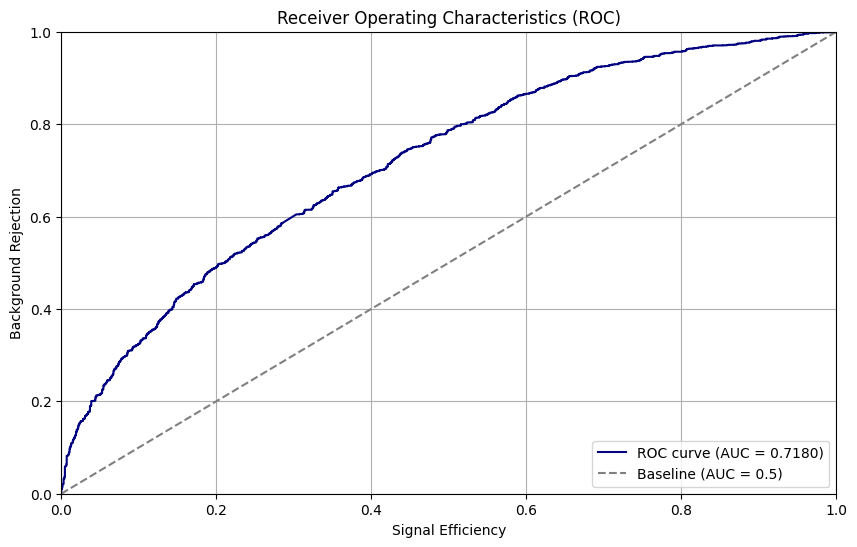

In [175]:
# Plot ROC Curve and show AUC
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='navy', label=f'ROC curve (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--', label='Baseline (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.ylabel('Background Rejection')
plt.xlabel('Signal Efficiency')
plt.title('Receiver Operating Characteristics (ROC)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

Analyze strength of features

       Feature    Importance
0    Feature_0  4.593700e-02
1    Feature_1  5.118019e-04
2    Feature_2  1.832959e-07
3    Feature_3  4.565337e-05
4    Feature_4  2.891436e-05
5    Feature_5  4.596950e-02
6    Feature_6  1.111766e-08
7    Feature_7  1.629815e-09
8    Feature_8  3.841706e-09
9    Feature_9  7.948256e-07
10  Feature_10  2.731257e-02
11  Feature_11  6.644404e-07
12  Feature_12  7.800036e-05
13  Feature_13  7.800496e-05
14  Feature_14  7.807475e-05
15  Feature_15  7.793825e-05
16  Feature_16  5.268608e-05
17  Feature_17  7.786241e-05
18  Feature_18  6.119511e-05
19  Feature_19  8.331041e-05
20  Feature_20  7.539918e-05
21  Feature_21  9.195320e-05
22  Feature_22  2.985506e-05
23  Feature_23  9.749358e-05
24  Feature_24  1.734262e-02
25  Feature_25  6.743926e-03
26  Feature_26  5.282997e-05
27  Feature_27  5.313137e-05
28  Feature_28  4.388858e-05
29  Feature_29  3.050081e-08
30  Feature_30  3.835982e-03


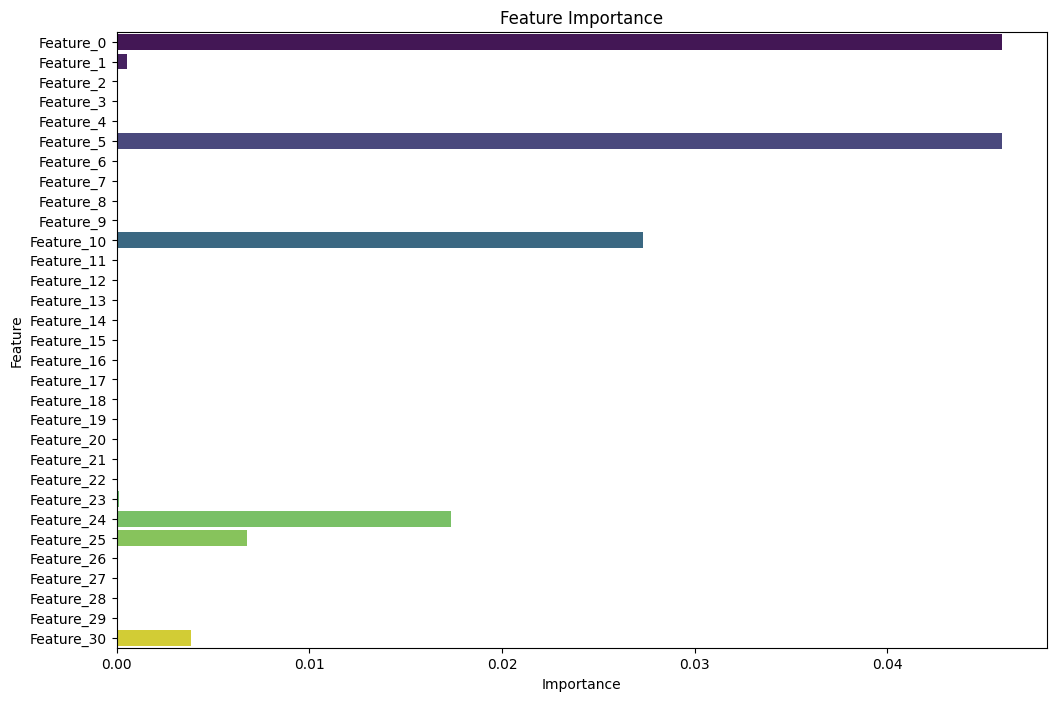

In [ ]:
import seaborn as sns

# Ensure model is in evaluation mode
model.eval()

# Prepare a sample batch for explanation
data = next(iter(test_loader))  # Adjust if necessary
x, edge_index, batch = data.x, data.edge_index, data.batch

G = nx.Graph()
edges = list(zip(edge_index[0].numpy(), edge_index[1].numpy()))
G.add_edges_from(edges)

# Initialize placeholders for feature importance
feature_importances = np.zeros(x.size(1))

# Compute importance for each feature
for feature_idx in range(x.size(1)):
    # Perturb the feature by setting it to zero
    x_perturbed = x.clone()
    x_perturbed[:, feature_idx] = 0

    # Predict with original features
    with torch.no_grad():
        orig_pred = model(x, edge_index, batch)
        perturbed_pred = model(x_perturbed, edge_index, batch)

    # Importance is computed as the difference in predictions
    importance = torch.mean(torch.abs(orig_pred - perturbed_pred)).item()
    feature_importances[feature_idx] = importance

# Convert to DataFrame for visualization
importance_df = pd.DataFrame({
    'Feature': [f'Feature_{i}' for i in range(x.size(1))],
    'Importance': feature_importances})

# Print feature importances
print(importance_df)

# Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis', hue='Feature', dodge=False)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [ ]:
for i, col in enumerate(feature_cols, start=0):
    print(f"{i}. {col}")

0. Jet0_Daughters_E
1. Jet0_Daughters_pT
2. Jet0_Daughters_ID
3. Jet0_Daughters_pX
4. Jet0_Daughters_pY
5. Jet0_Daughters_pZ
6. Jet0_Daughters_Eta
7. Jet0_Daughters_Phi
8. Jet0_Daughters_Q
9. Jet0_Daughters_IP
10. Jet0_Daughters_IPCHI2
11. Jet0_Daughters_IPraw
12. Jet0_Daughters_NNe
13. Jet0_Daughters_NNk
14. Jet0_Daughters_NNp
15. Jet0_Daughters_NNpi
16. Jet0_Daughters_NNmu
17. Jet0_Daughters_Chi2
18. Jet0_Daughters_QoverP
19. Jet0_Daughters_trackX
20. Jet0_Daughters_trackY
21. Jet0_Daughters_trackZ
22. Jet0_Daughters_trackVX
23. Jet0_Daughters_trackVY
24. Jet0_Daughters_trackVZ
25. Jet0_Daughters_CaloNeutralEcal
26. Jet0_Daughters_CaloNeutralHcal2Ecal
27. Jet0_Daughters_CaloNeutralE49
28. Jet0_Daughters_CaloNeutralPrs
29. Jet0_Eta
30. Jet0_PT
